# Deep Neural Network for Image Classification: Application

You will use use the functions you'd implemented in the previous assignment to build a deep network, and apply it to rose vs non-rose classification. 
**After this assignment you will be able to:**
- Build and apply a deep neural network to supervised learning. 

Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [436]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Dataset


**Problem Statement**: You are given a dataset ("FlowerColorImages.h5") containing:
    - a training set of m_train images labelled as rose (1) or non-rose (0)
    - a test set of m_test images labelled as rose and non-rose
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [437]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

In [438]:
# Example of a rose
index = 14
#print(train_x_orig)
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]] +  ".")


y = 1. It's a rose.


In [439]:
# Example of a non-rose
index = 1
#print(train_x_orig)
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]] +  ".")

y = 0. It's a non-rose.


In [440]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 129
Number of testing examples: 80
Each image is of size: (128, 128, 3)
train_x_orig shape: (129, 128, 128, 3)
train_y shape: (1, 129)
test_x_orig shape: (80, 128, 128, 3)
test_y shape: (1, 80)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [441]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (49152, 129)
test_x's shape: (49152, 80)


$49,152$ equals $128 \times 128 \times 3$ which is the size of one reshaped image vector.

## 3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

You will build two different models:
- A 2-layer neural network
- An L-layer deep neural network

You will then compare the performance of these models, and also try out different values for $L$. 

Let's look at the two architectures.

### 3.1 - 2-layer neural network

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: 2-layer neural network. <br> The model can be summarized as: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***. </center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- You then add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- You then repeat the same process.
- You multiply the resulting vector by $W^{[2]}$ and add your intercept (bias). 
- Finally, you take the sigmoid of the result. If it is greater than 0.5, you classify it to be a cat.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 3</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

### 3.3 - General methodology

As usual you will follow the Deep Learning methodology to build the model:
    1. Initialize parameters / Define hyperparameters
    2. Loop for num_iterations:
        a. Forward propagation
        b. Compute cost function
        c. Backward propagation
        d. Update parameters (using parameters, and grads from backprop) 
    4. Use trained parameters to predict labels

Let's now implement those two models!

## 4 - Two-layer neural network

**Question**:  Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [442]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 49152     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [443]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(10)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1,b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2,cache2, "sigmoid")
        dA0, dW1, db1 =  linear_activation_backward(dA1,cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Run the cell below to train your parameters. See if your model runs. The cost should be decreasing. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

In [445]:
np.seterr(all='raise')
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

Cost after iteration 0: 0.6880700904336435
Cost after iteration 100: 0.061281453024383425
Cost after iteration 200: 0.04777367675478758
Cost after iteration 300: 0.03875674347484501
Cost after iteration 400: 0.03228417174272315
Cost after iteration 500: 0.027432978089357737
Cost after iteration 600: 0.02375537396463093
Cost after iteration 700: 0.020842335993826074
Cost after iteration 800: 0.018493914274362193
Cost after iteration 900: 0.016592398947795566
Cost after iteration 1000: 0.015035151163262183
Cost after iteration 1100: 0.013711045734213634
Cost after iteration 1200: 0.012590724813754782
Cost after iteration 1300: 0.011628546082848598
Cost after iteration 1400: 0.01080547111867692
Cost after iteration 1500: 0.010076117265781415
Cost after iteration 1600: 0.009441409111770896
Cost after iteration 1700: 0.008872923000111528
Cost after iteration 1800: 0.008374326790779273
Cost after iteration 1900: 0.007920137786694046
Cost after iteration 2000: 0.007512402029675567
Cost after 

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6880700904336435 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.061281453024383425 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.006222185841049876 </td>
    </tr>
</table>

Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [446]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


**Expected Output**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [447]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.8875


**Expected Output**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.8875 </td>
    </tr>
</table>

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and we will talk about it in the next course. Early stopping is a way to prevent overfitting. 

Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an $L$-layer model.

## 5 - L-layer Neural Network

**Question**: Use the helper functions you have implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [448]:
### CONSTANTS ###
layers_dims = [49152, 20, 7, 5, 1] #  4-layer model

In [449]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take up to 5 minutes to run 2500 iterations. Check if the "Cost after iteration 0" matches the expected output below, if not click on the square (⬛) on the upper bar of the notebook to stop the cell and try to find your error.

Cost after iteration 0: 0.724755
Cost after iteration 100: 0.044396
Cost after iteration 200: 0.001125
Cost after iteration 300: 0.000454
Cost after iteration 400: 0.000271
Cost after iteration 500: 0.000189
Cost after iteration 600: 0.000143
Cost after iteration 700: 0.000114
Cost after iteration 800: 0.000094
Cost after iteration 900: 0.000080
Cost after iteration 1000: 0.000069
Cost after iteration 1100: 0.000061
Cost after iteration 1200: 0.000054
Cost after iteration 1300: 0.000049
Cost after iteration 1400: 0.000044
Cost after iteration 1500: 0.000040
Cost after iteration 1600: 0.000037
Cost after iteration 1700: 0.000034
Cost after iteration 1800: 0.000032
Cost after iteration 1900: 0.000030
Cost after iteration 2000: 0.000028
Cost after iteration 2100: 0.000026
Cost after iteration 2200: 0.000025
Cost after iteration 2300: 0.000023
Cost after iteration 2400: 0.000022


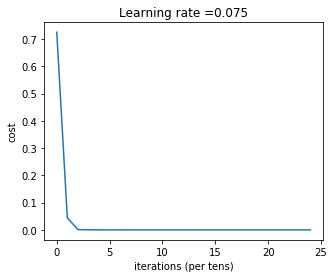

In [450]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Expected Output**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [451]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 1.0


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
   1.0
    </td>
    </tr>
</table>

In [452]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8999999999999999


**Expected Output**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.89999999 </td>
    </tr>
</table>

Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is good performance for this task. Nice job! 

Though in the next course on "Improving deep neural networks" you will learn how to obtain even higher accuracy by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations, and others you'll also learn in the next course). 

##  6) First Look Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

In [453]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Many roses on the picture
- Unusual rose color and species
- Camera Angle
- Brightness of the picture
- Scale variation (rose is very large or small in image) 

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

##  7) EXPERIMENTATION

We experiment basis on the work developed above using:
- Layer dimensions
- Number of iterations
- Learning rate

Functions:
* Multi Layer Model
* Get the accuracy with the testing data
* Printing wrong predictions

## EXPERIMENT 1

**More neurons**
**Less learning rate**

Cost after iteration 0: 0.656766
Cost after iteration 100: 0.061817
Cost after iteration 200: 0.051568
Cost after iteration 300: 0.043902
Cost after iteration 400: 0.037272


Accuracy: 0.8875


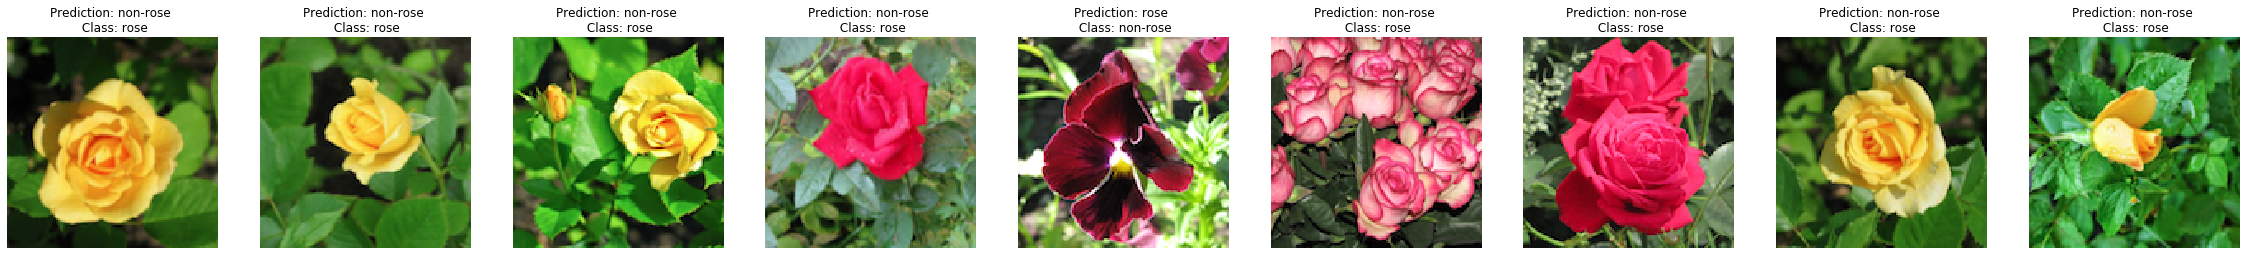

In [454]:
layers_dims = [49152, 20, 15, 25, 1]
num_iterations = 500
learning_rate=0.04
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print_mislabeled_images(classes, test_x, test_y, pred_test)

## EXPERIMENT 2

**More neurons**
**Less learning rate**

Cost after iteration 0: 0.722173
Cost after iteration 100: 0.051617
Cost after iteration 200: 0.012379
Cost after iteration 300: 0.005777
Cost after iteration 400: 0.003492


Accuracy: 0.8875


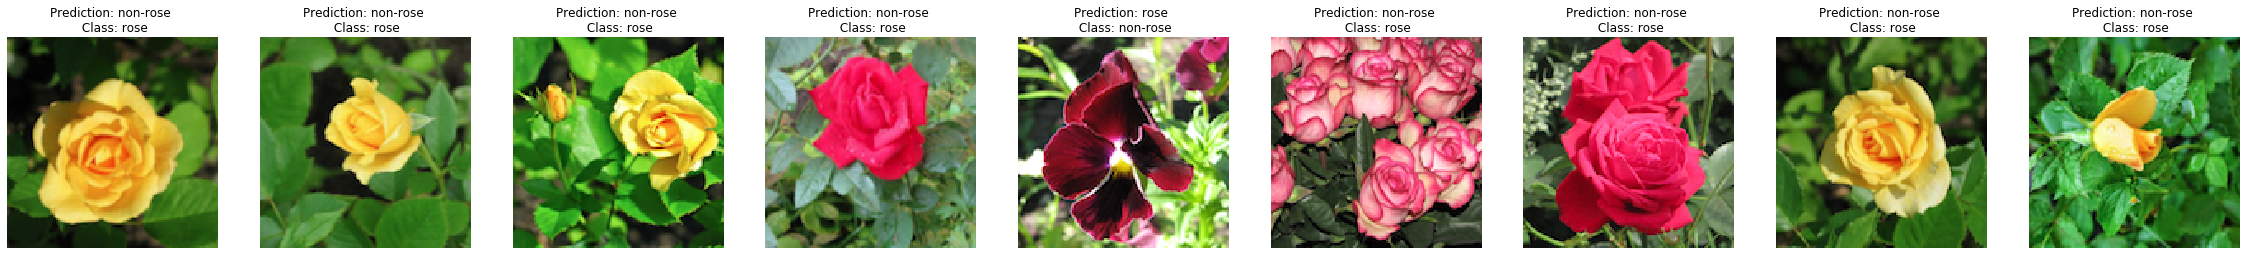

In [455]:
layers_dims = [49152, 20, 25, 25, 1]
num_iterations = 500
learning_rate=0.009
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print_mislabeled_images(classes, test_x, test_y, pred_test)

## EXPERIMENT 3

**Less neurons**
**More learning rate**

Cost after iteration 0: 0.686939
Cost after iteration 100: 0.068799
Cost after iteration 200: 0.063452


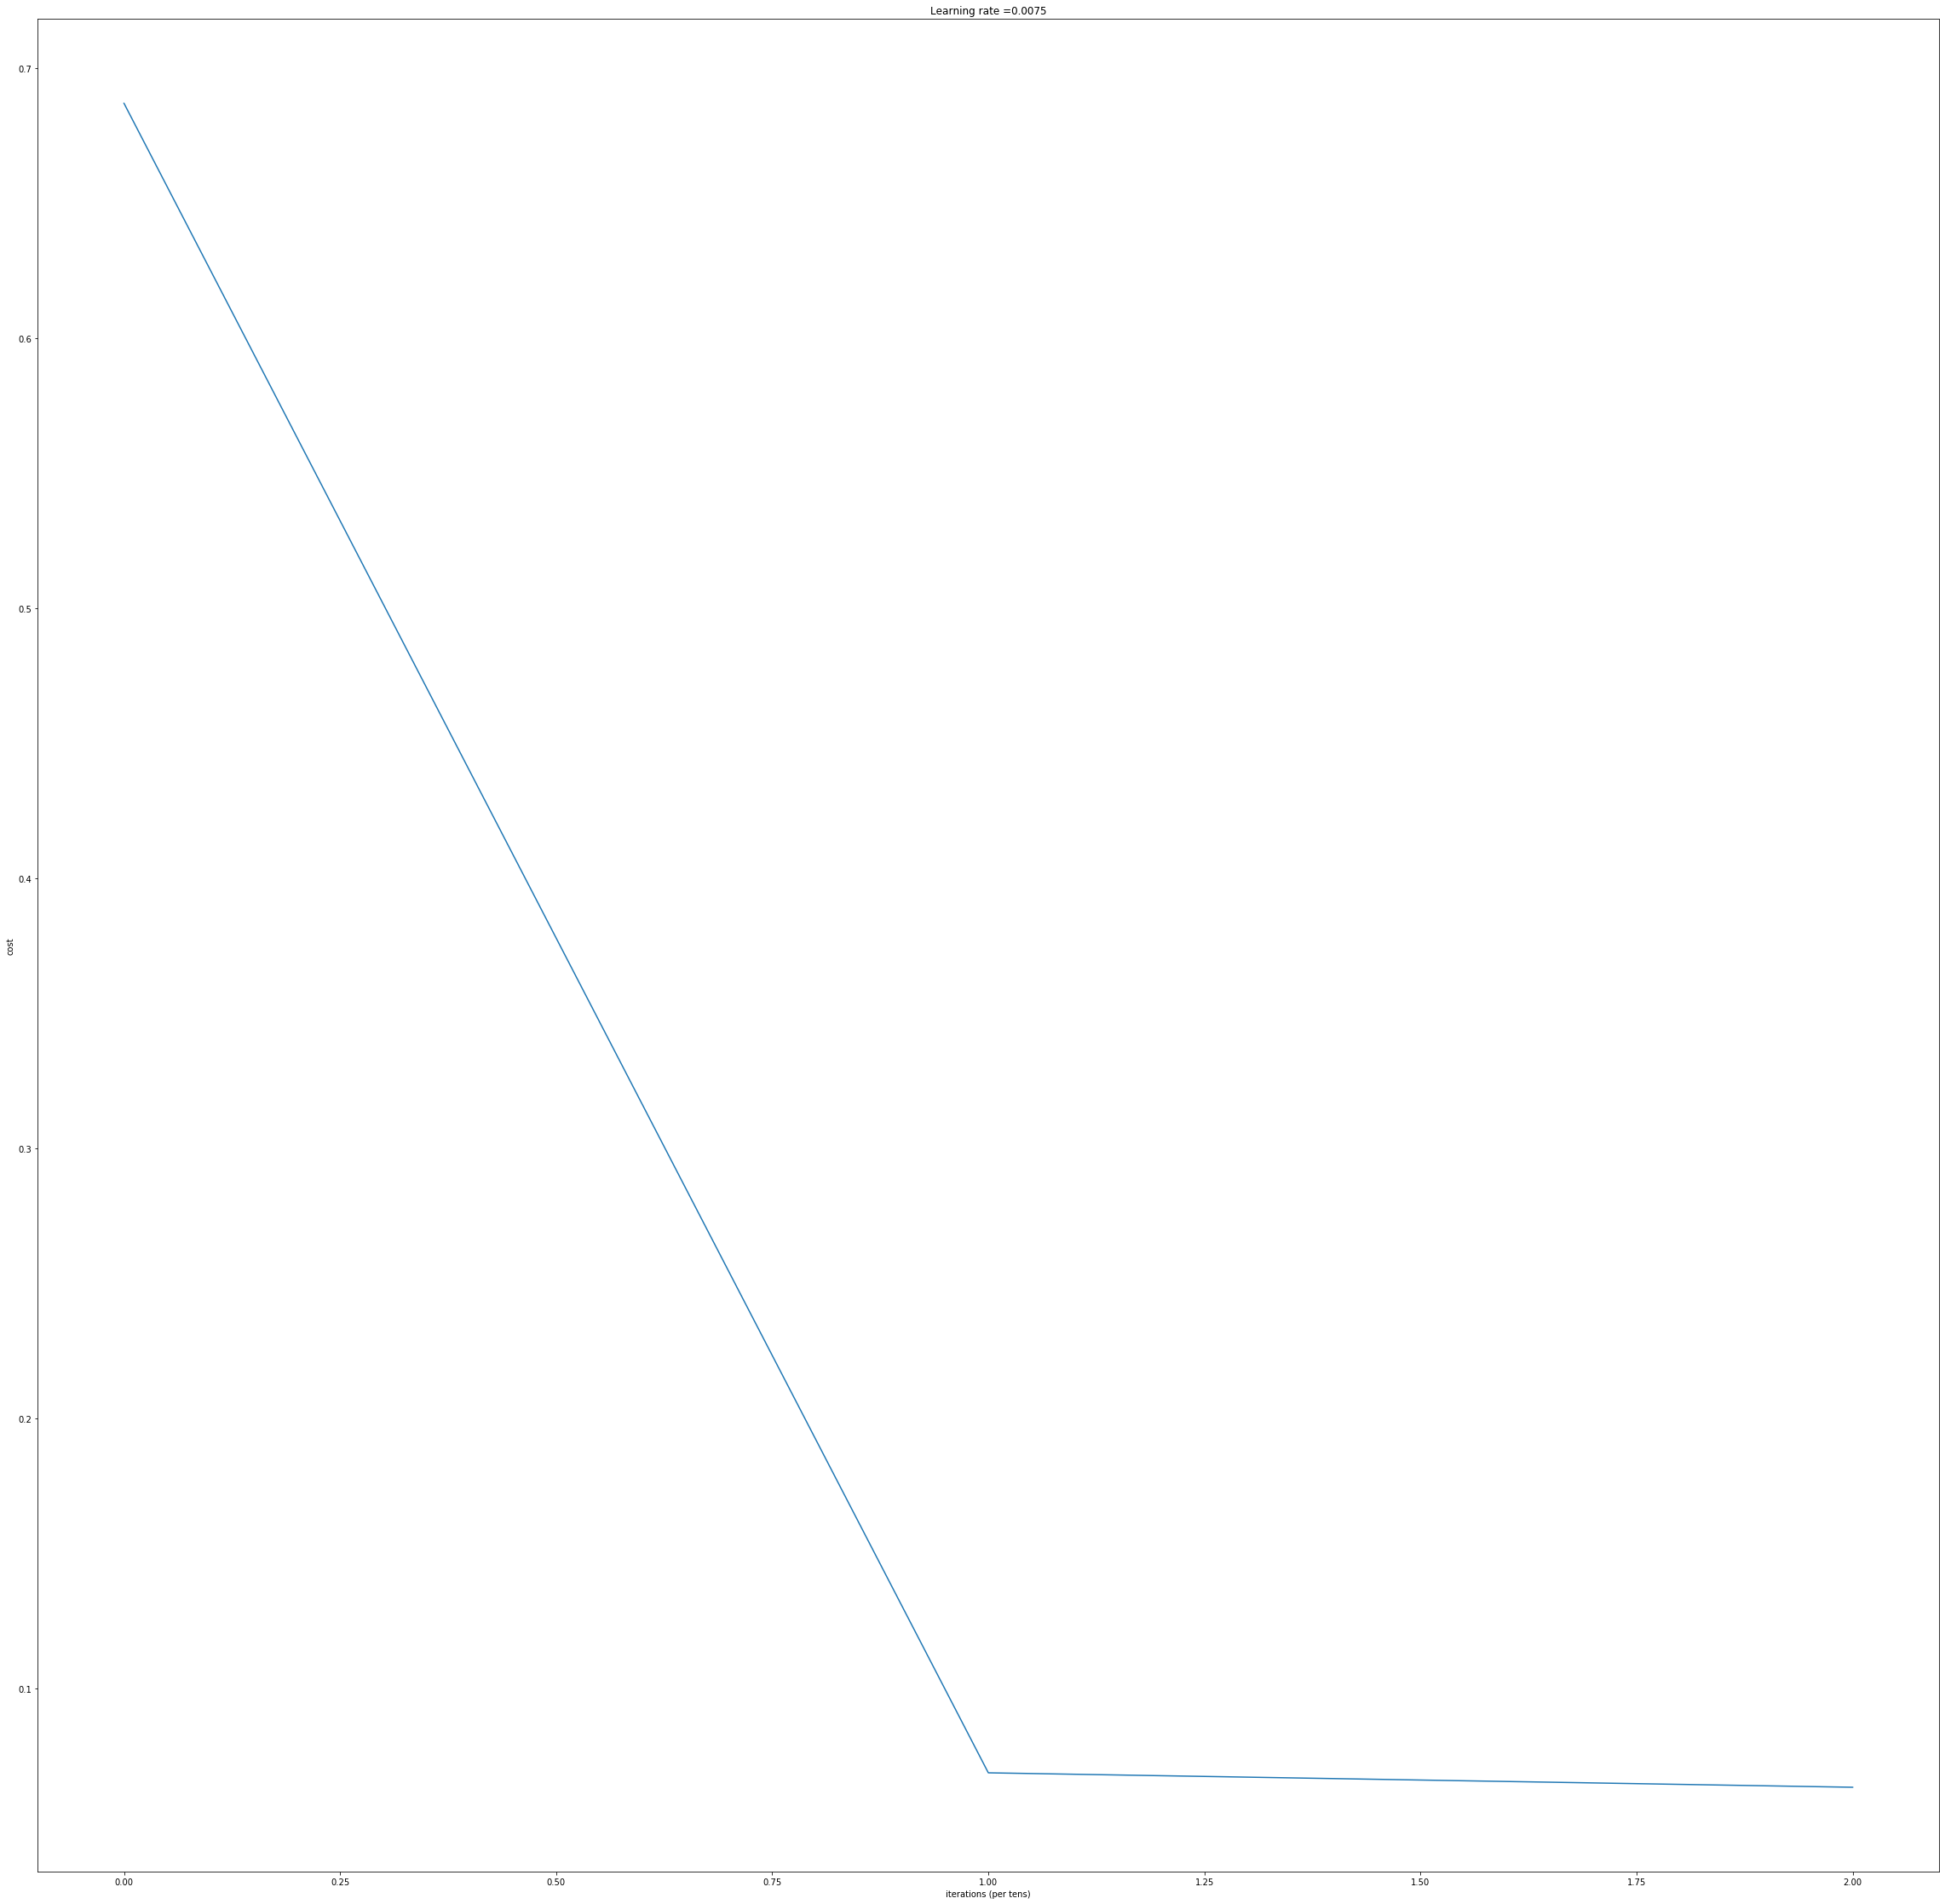

Accuracy: 0.8999999999999999


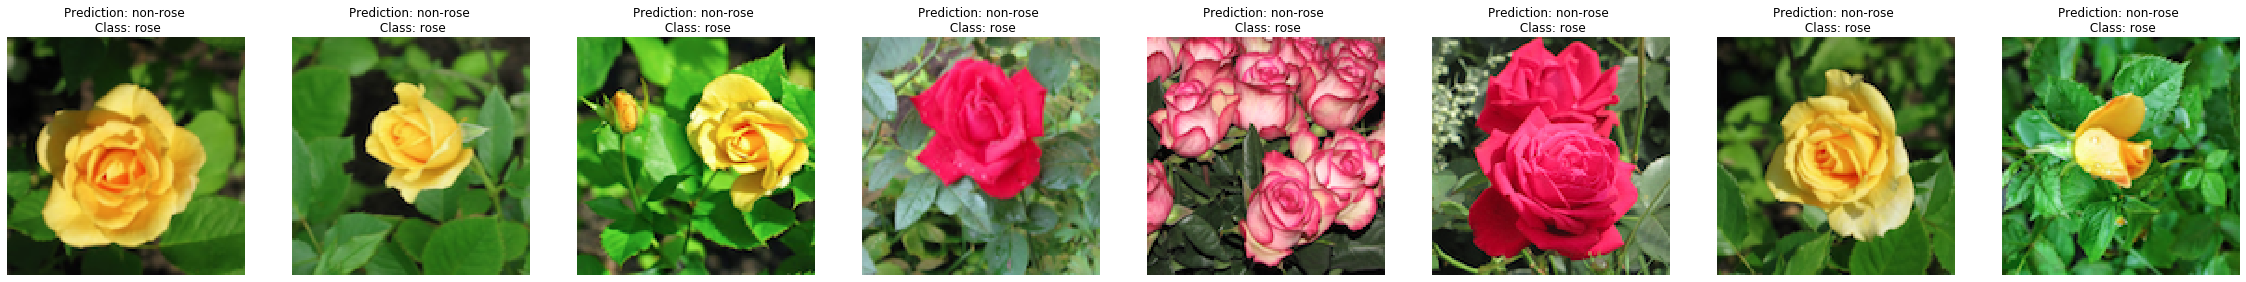

In [458]:
layers_dims = [49152, 7, 2, 7, 1]
num_iterations = 201
learning_rate=0.0075
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print_mislabeled_images(classes, test_x, test_y, pred_test)

## EXPERIMENT 4

**Less neurons**
**More learning rate**

Cost after iteration 0: 0.580972
Cost after iteration 100: 0.072427
Cost after iteration 200: 0.021045
Cost after iteration 300: 0.008929
Cost after iteration 400: 0.005136
Cost after iteration 500: 0.003449
Cost after iteration 600: 0.002530
Cost after iteration 700: 0.001967
Cost after iteration 800: 0.001593
Cost after iteration 900: 0.001327
Cost after iteration 1000: 0.001131
Cost after iteration 1100: 0.000981
Cost after iteration 1200: 0.000863
Cost after iteration 1300: 0.000768
Cost after iteration 1400: 0.000691
Cost after iteration 1500: 0.000626
Cost after iteration 1600: 0.000571
Cost after iteration 1700: 0.000525
Cost after iteration 1800: 0.000485
Cost after iteration 1900: 0.000450
Cost after iteration 2000: 0.000419
Cost after iteration 2100: 0.000392
Cost after iteration 2200: 0.000368
Cost after iteration 2300: 0.000346
Cost after iteration 2400: 0.000327


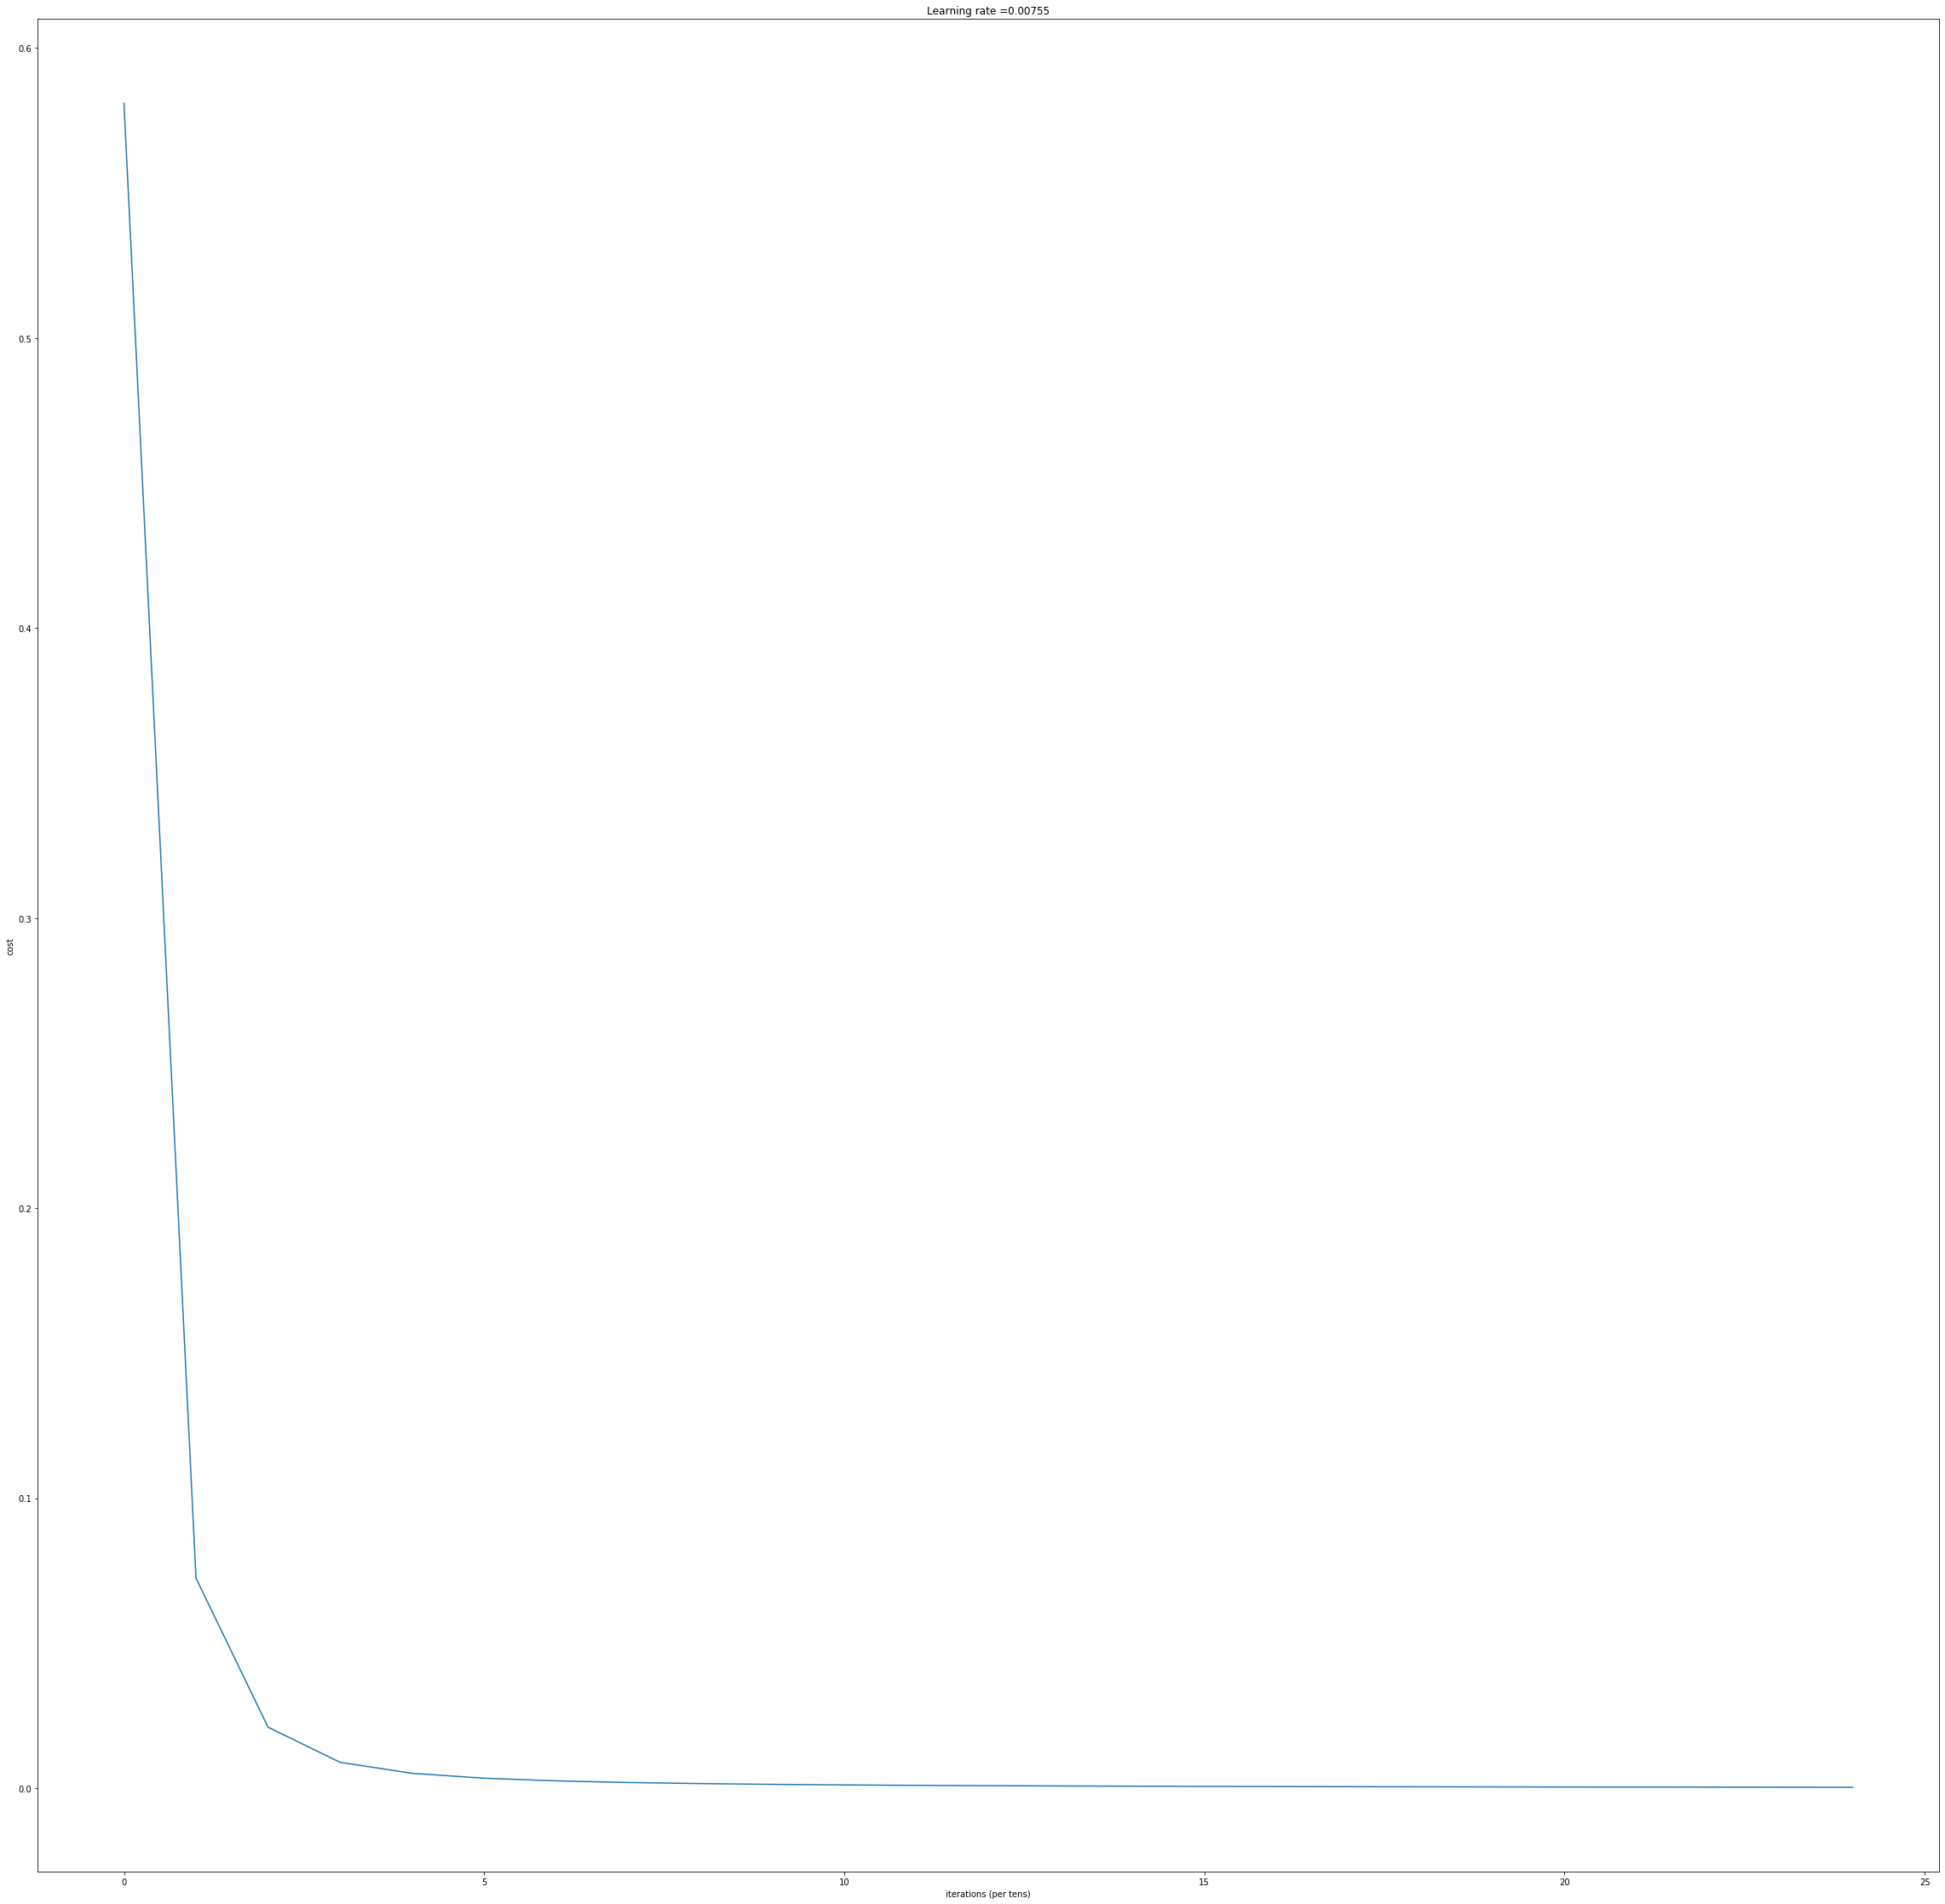

Accuracy: 0.8875


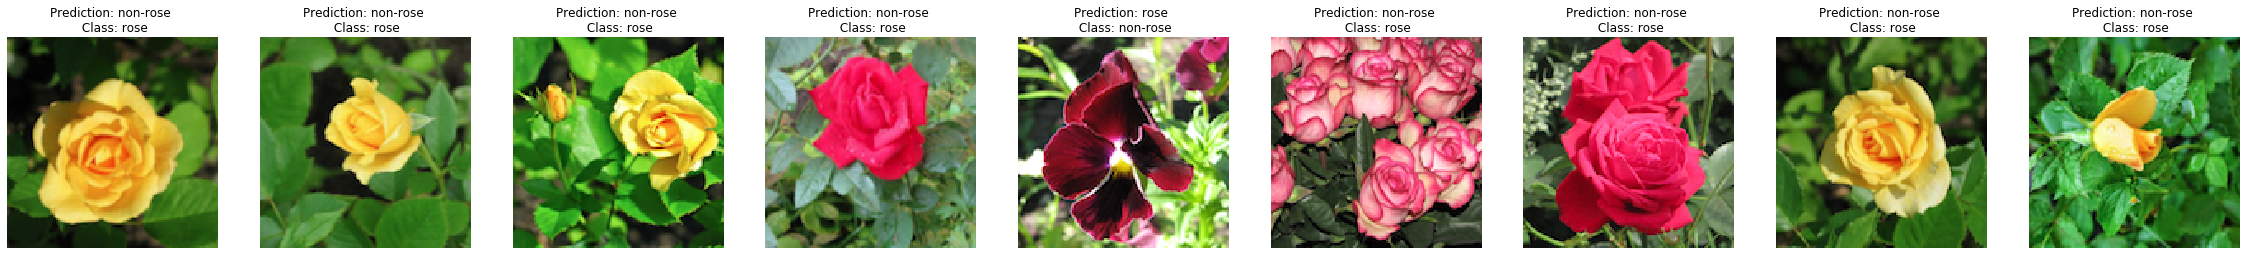

In [459]:
layers_dims = [49152, 100, 75, 100, 1]
num_iterations = 2500
learning_rate=0.00755
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print_mislabeled_images(classes, test_x, test_y, pred_test)

## EXPERIMENT 5

**More neurons**
**Less learning rate**

Cost after iteration 0: 0.619880
Cost after iteration 100: 0.253592
Cost after iteration 200: 0.207643
Cost after iteration 300: 0.166165
Cost after iteration 400: 0.131687
Cost after iteration 500: 0.106594
Cost after iteration 600: 0.086126
Cost after iteration 700: 0.069775
Cost after iteration 800: 0.056826
Cost after iteration 900: 0.046665
Cost after iteration 1000: 0.038656
Cost after iteration 1100: 0.032454
Cost after iteration 1200: 0.027597
Cost after iteration 1300: 0.023743
Cost after iteration 1400: 0.020658


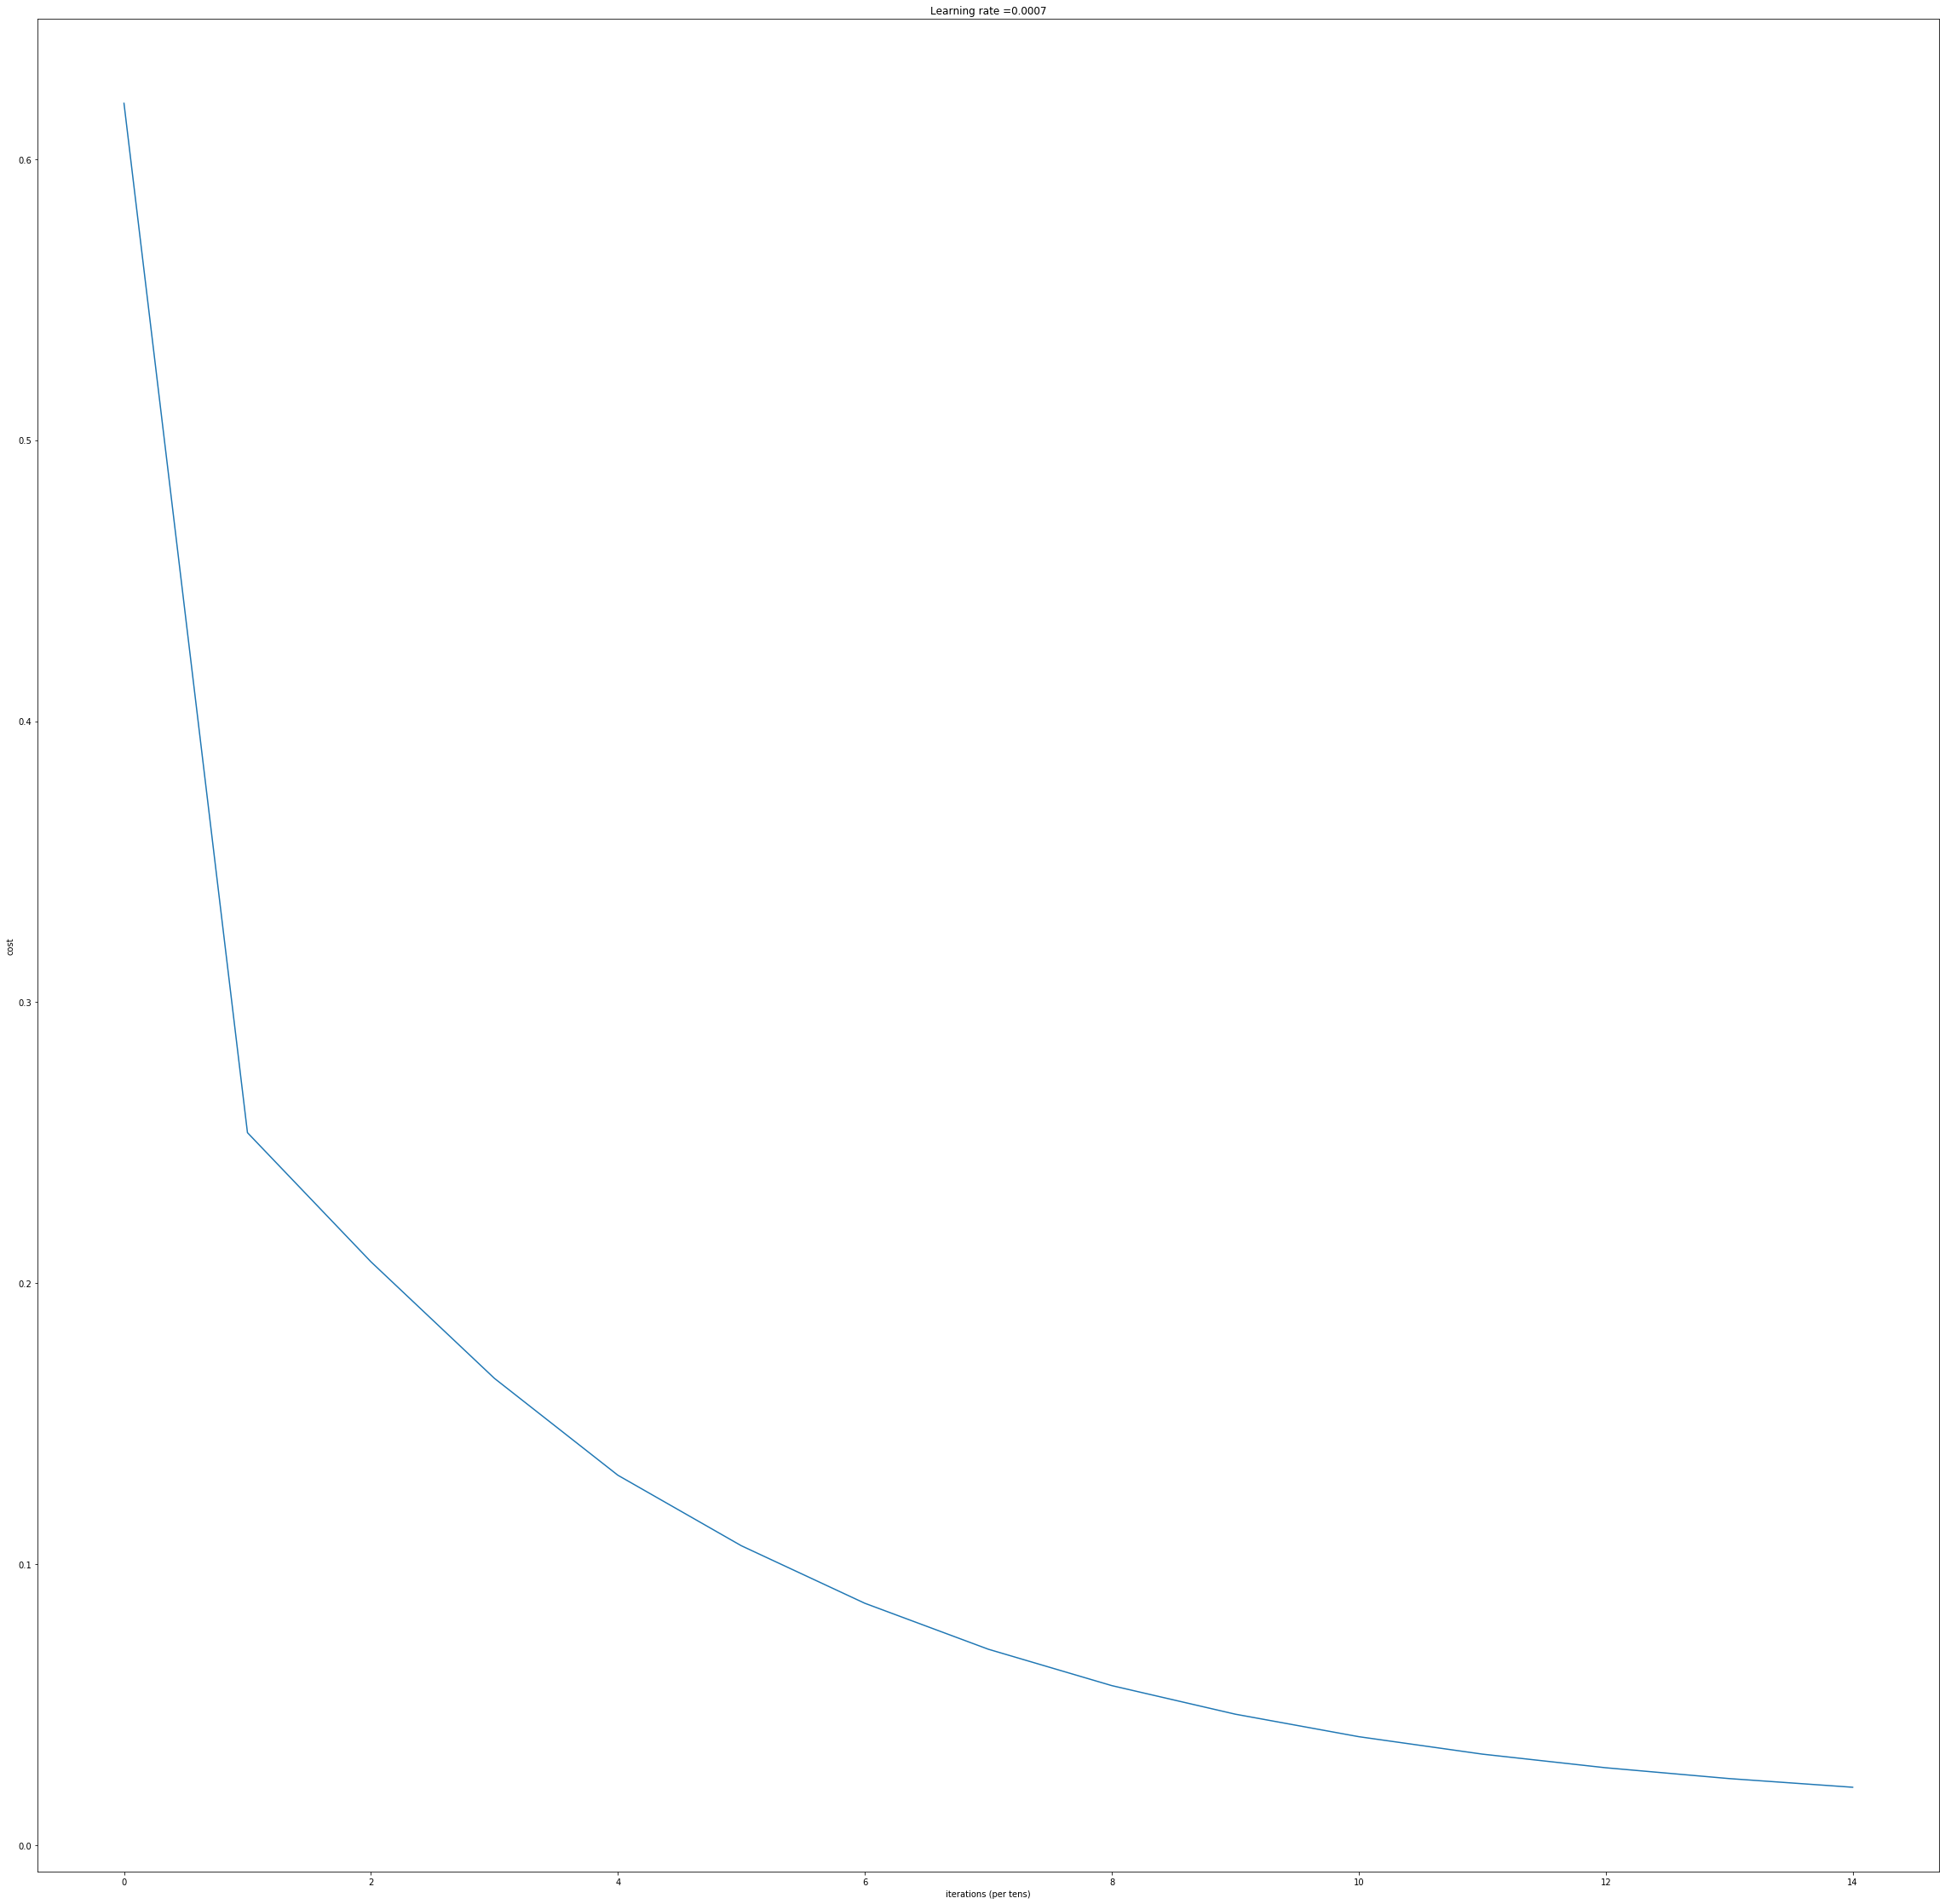

Accuracy: 0.8500000000000001


In [429]:
layers_dims = [49152, 15, 20, 15, 1]
num_iterations = 500
learning_rate=0.0007
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print_mislabeled_images(classes, test_x, test_y, pred_test)

## EXPERIMENT 6

**More LAYERS**
**Less learning rate**

Cost after iteration 0: 0.689832
Cost after iteration 100: 0.116951
Cost after iteration 200: 0.040821
Cost after iteration 300: 0.013086
Cost after iteration 400: 0.006158
Cost after iteration 500: 0.003695
Cost after iteration 600: 0.002525
Cost after iteration 700: 0.001872
Cost after iteration 800: 0.001466
Cost after iteration 900: 0.001192


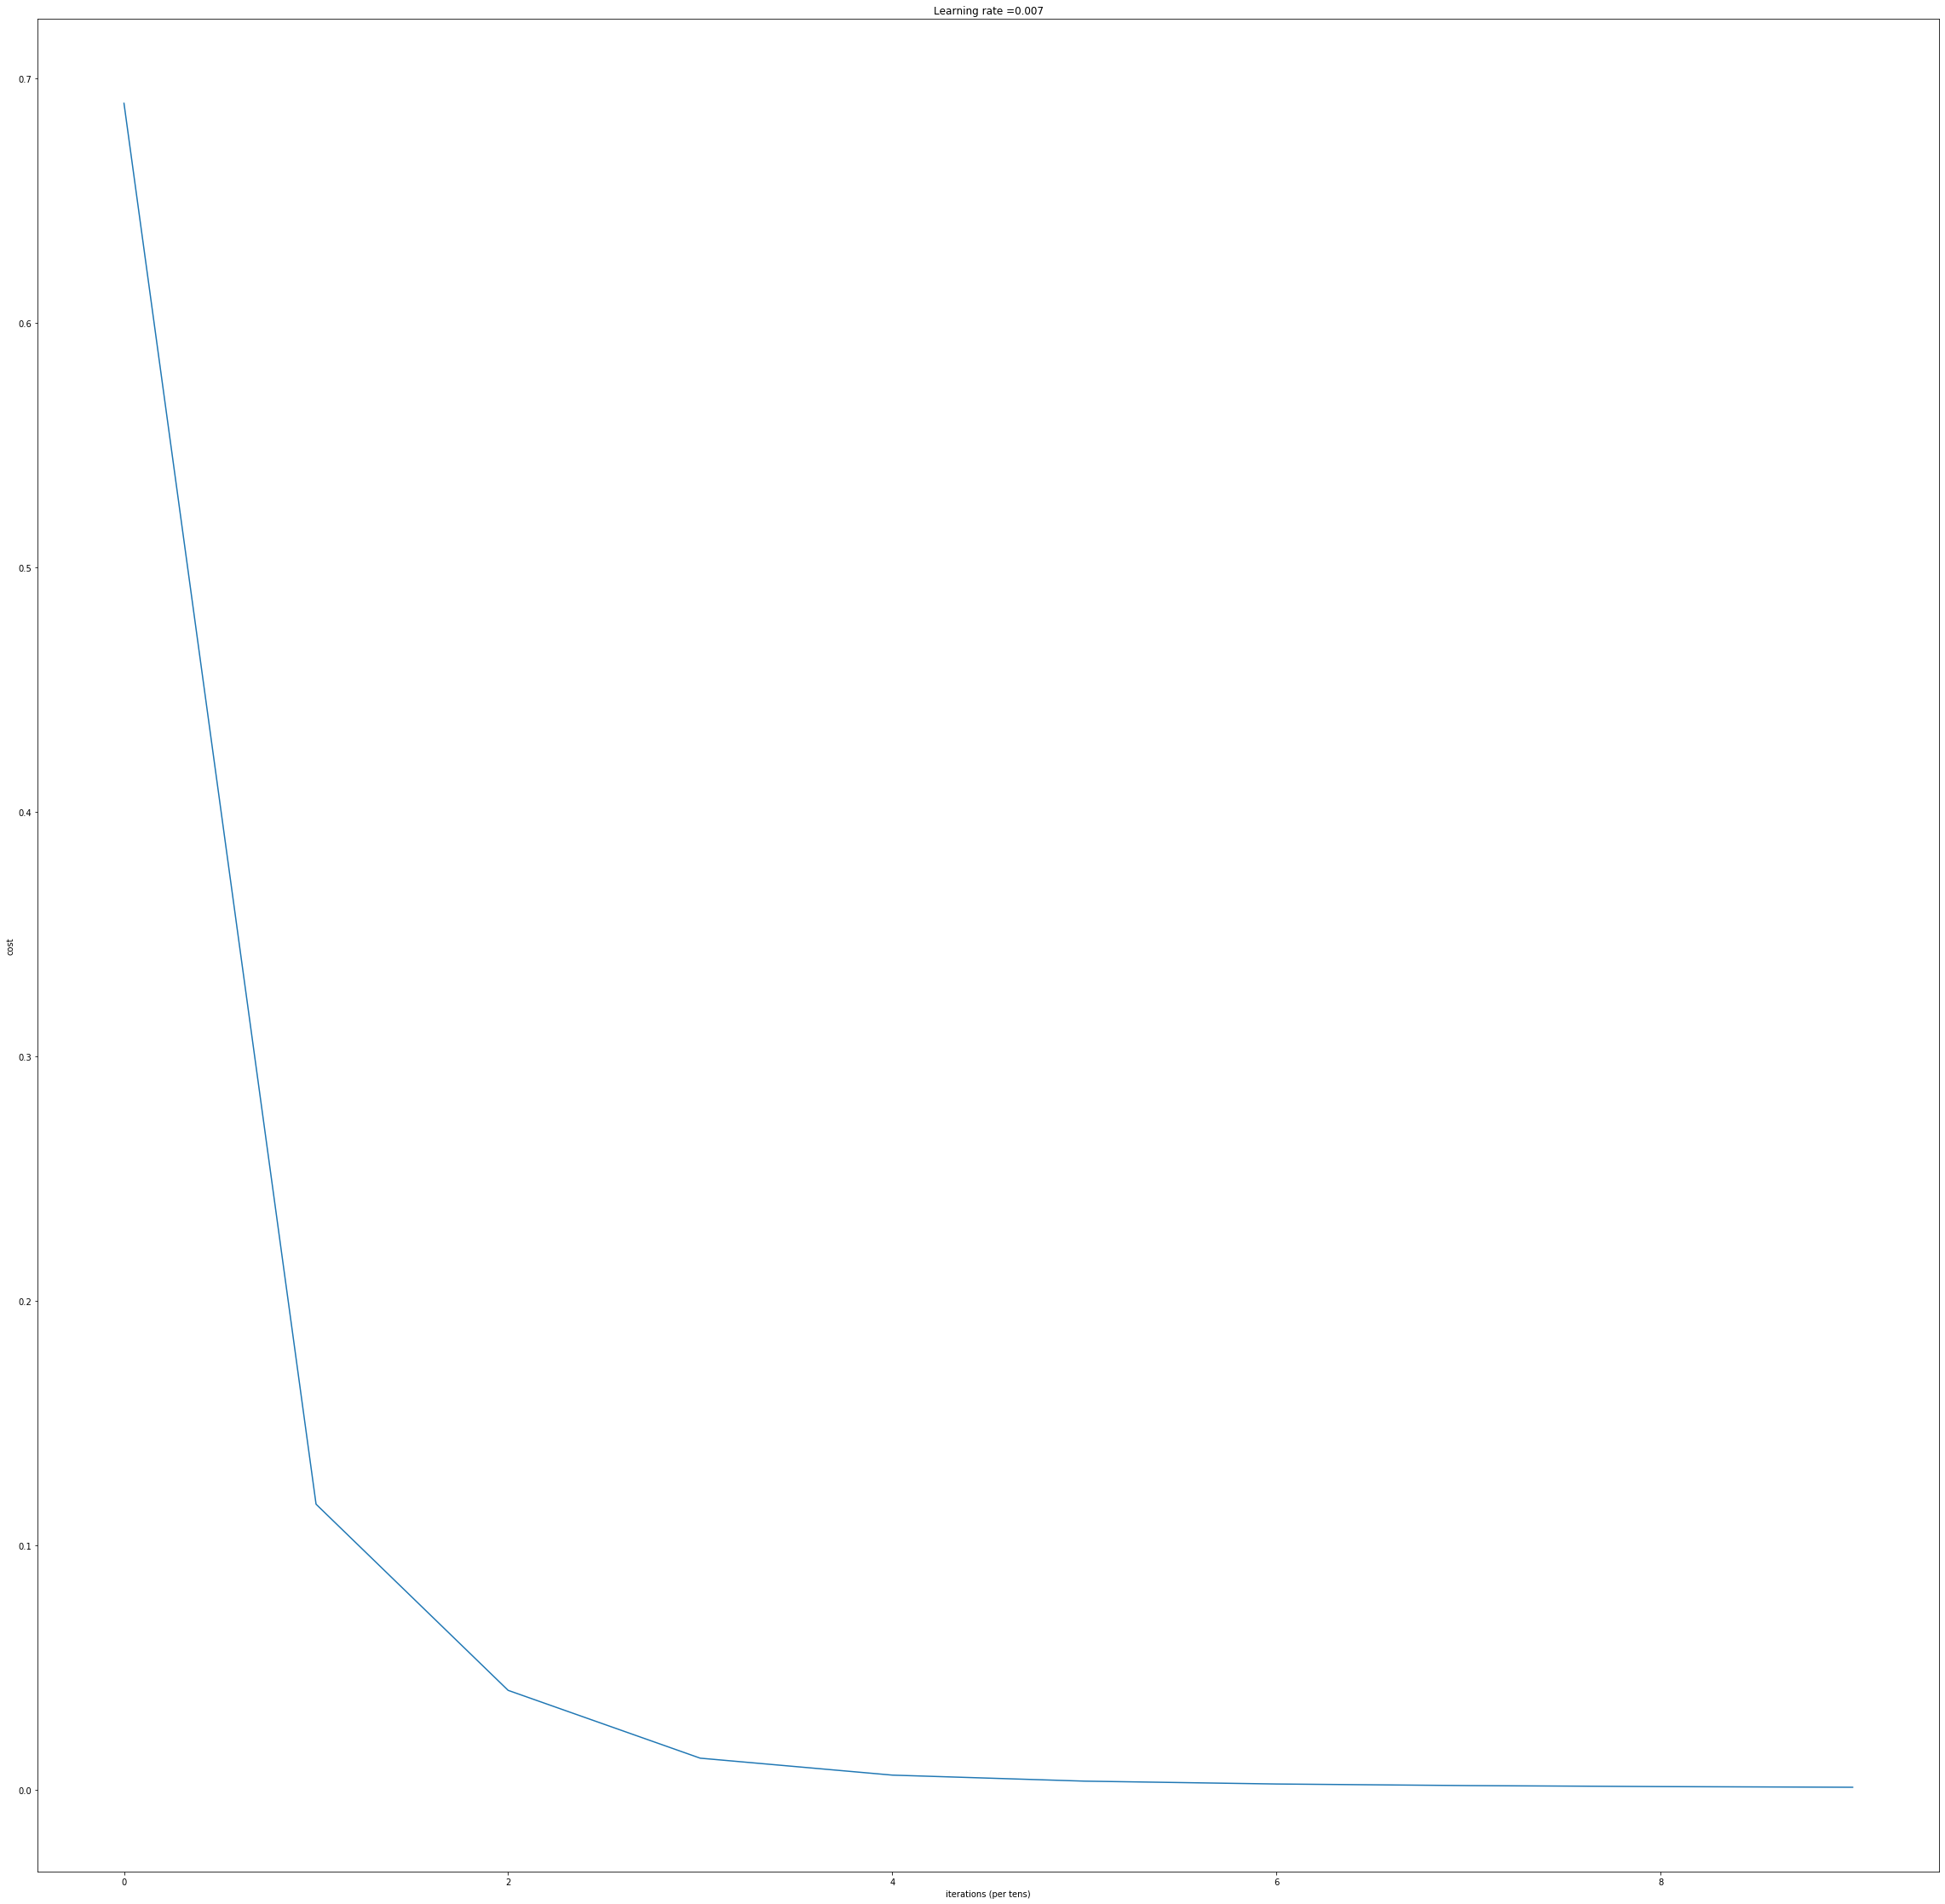

Accuracy: 0.8875


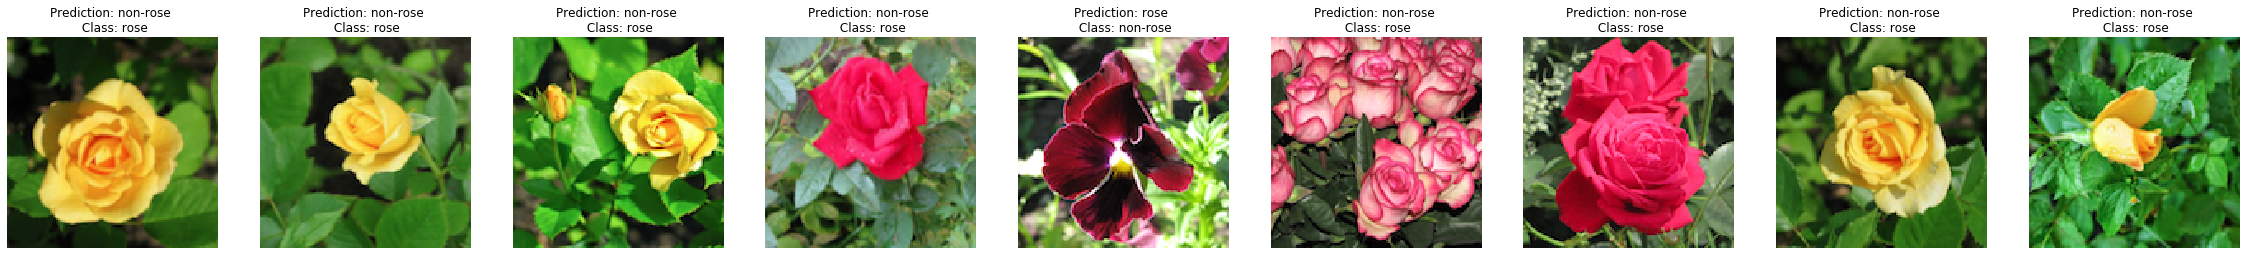

In [476]:
layers_dims = [49152, 120, 15, 10,30,20, 1]
num_iterations = 1000
learning_rate=0.007
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print_mislabeled_images(classes, test_x, test_y, pred_test)

## EXPERIMENT 7

**INITIAL PARAMTERS**


Cost after iteration 0: 0.724755
Cost after iteration 100: 0.588304
Cost after iteration 200: 0.516240
Cost after iteration 300: 0.465574
Cost after iteration 400: 0.429242
Cost after iteration 500: 0.402668
Cost after iteration 600: 0.382870
Cost after iteration 700: 0.367875
Cost after iteration 800: 0.356350
Cost after iteration 900: 0.347380
Cost after iteration 1000: 0.340321
Cost after iteration 1100: 0.334714
Cost after iteration 1200: 0.330222
Cost after iteration 1300: 0.326599
Cost after iteration 1400: 0.323657
Cost after iteration 1500: 0.321257
Cost after iteration 1600: 0.319289
Cost after iteration 1700: 0.317669
Cost after iteration 1800: 0.316330
Cost after iteration 1900: 0.315220
Cost after iteration 2000: 0.314298
Cost after iteration 2100: 0.313530
Cost after iteration 2200: 0.312888
Cost after iteration 2300: 0.312351
Cost after iteration 2400: 0.311901


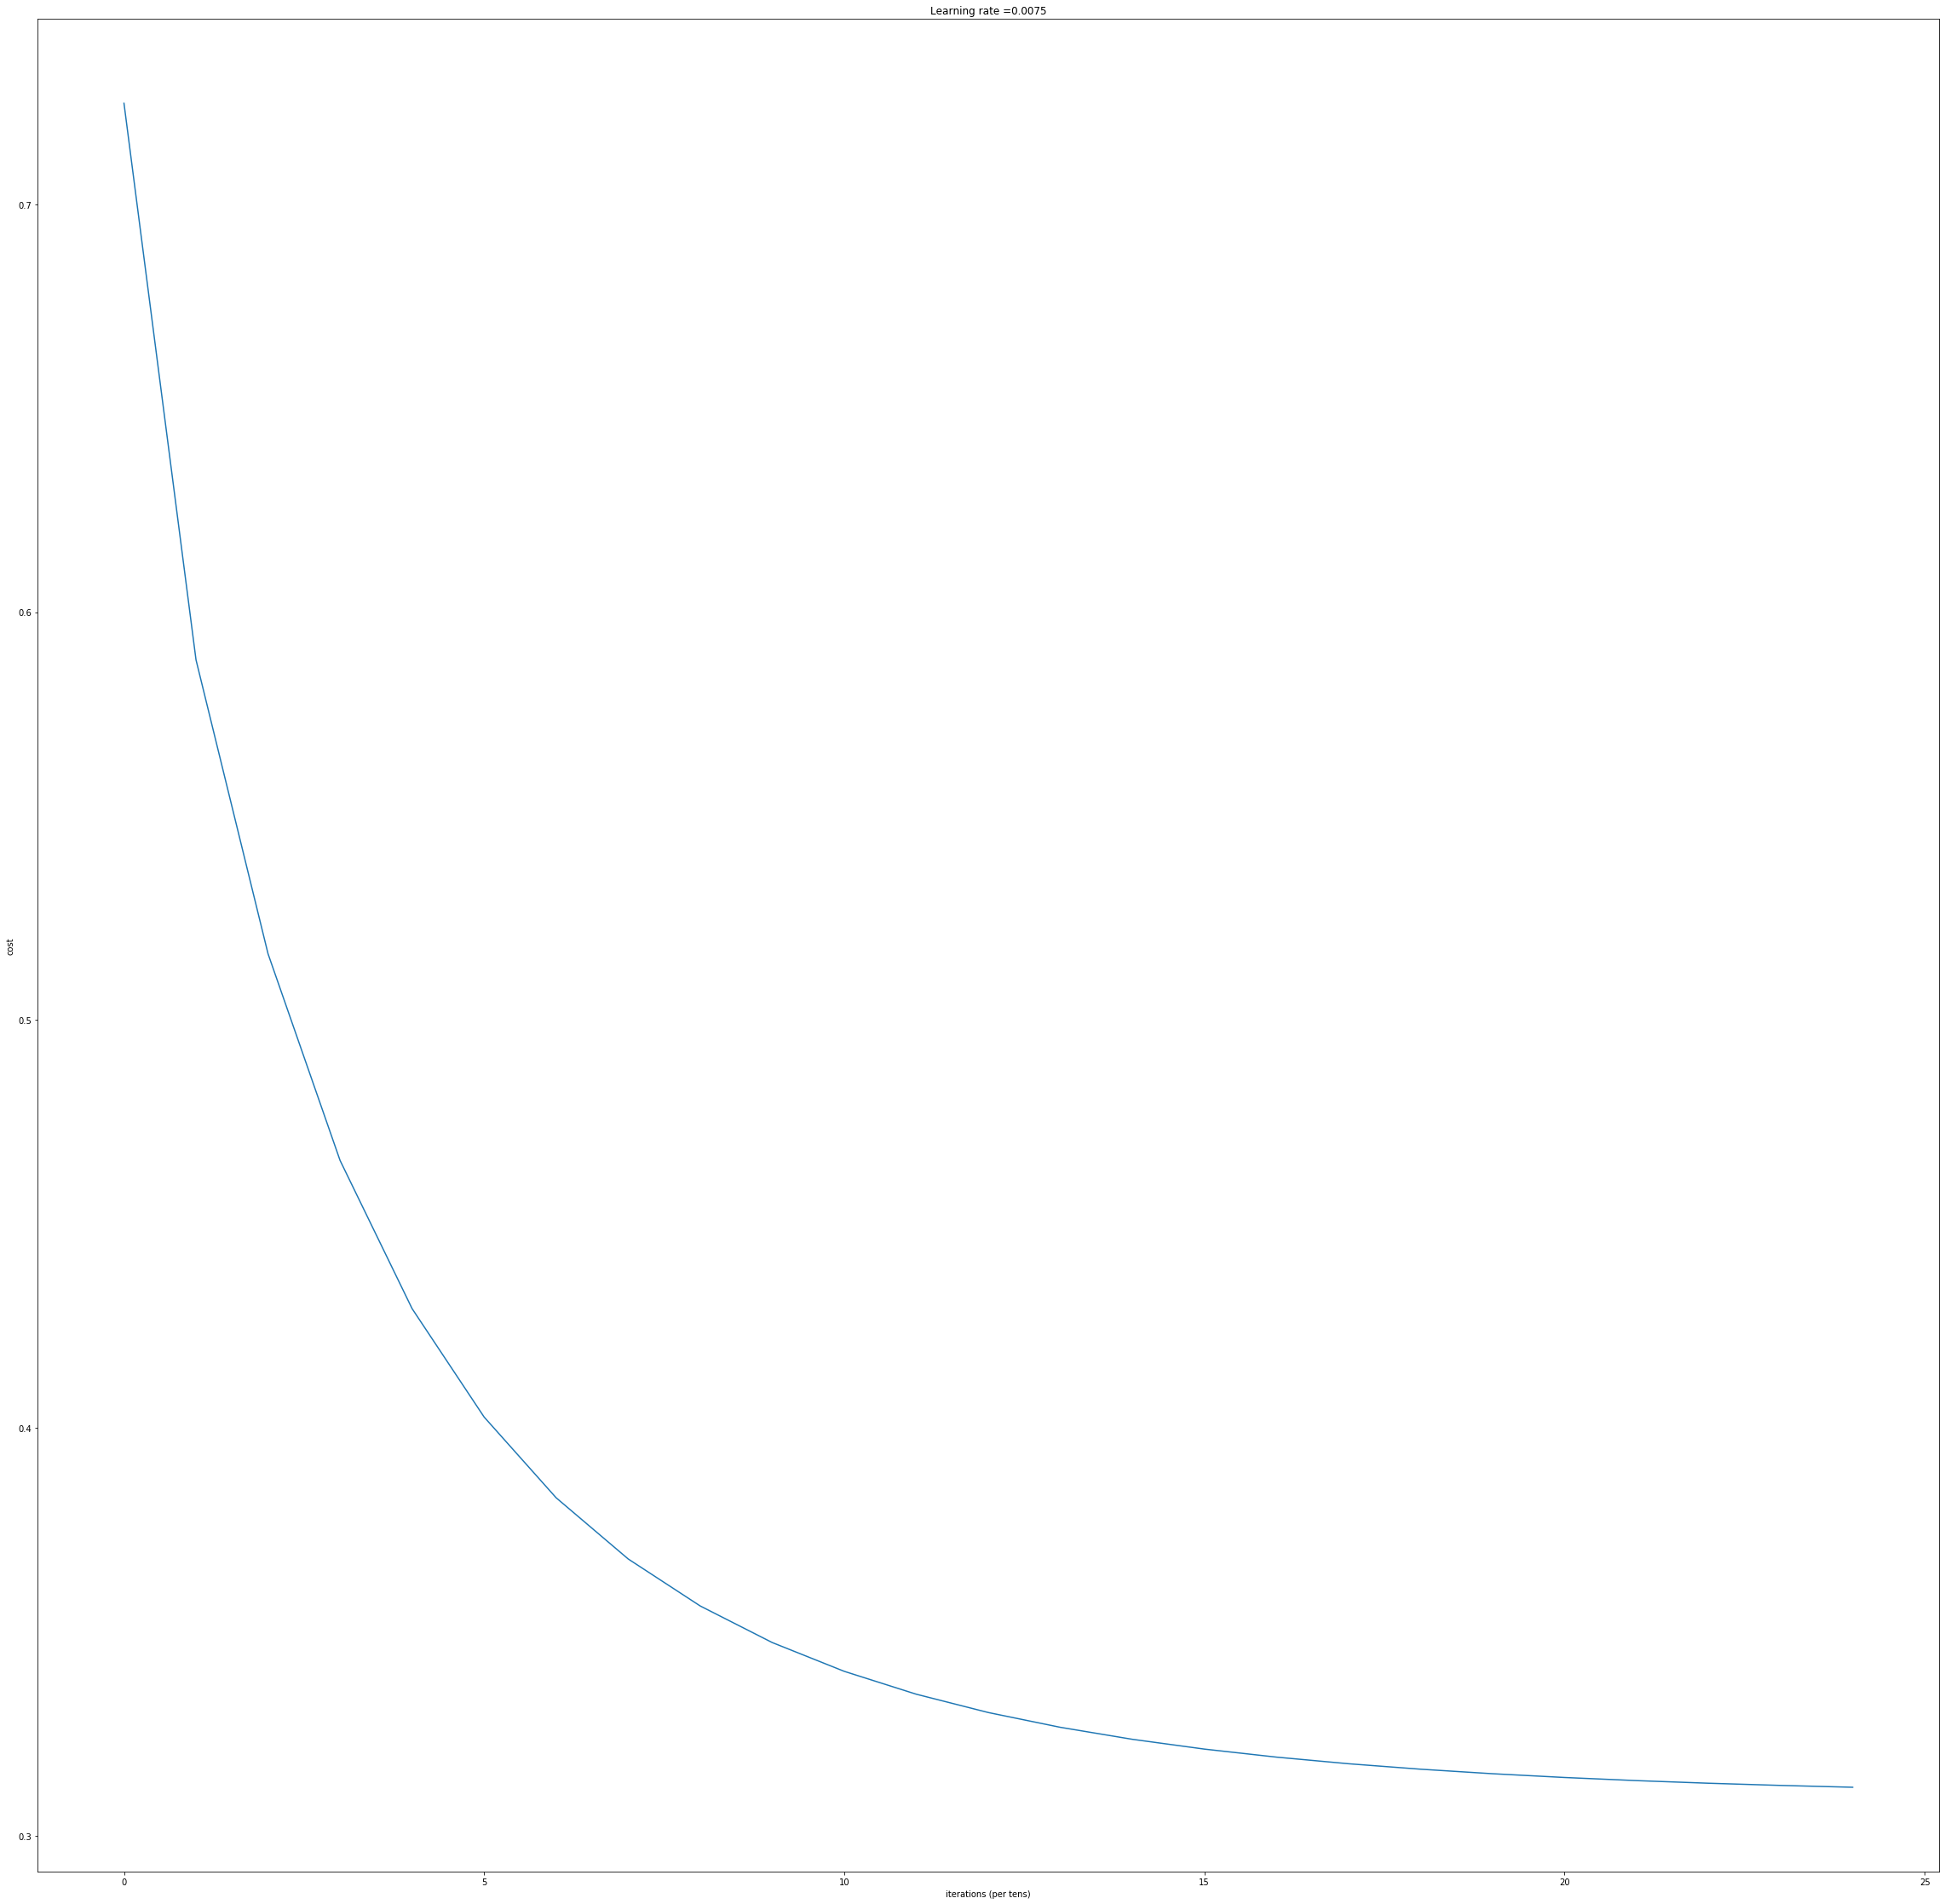

Accuracy: 0.8999999999999999


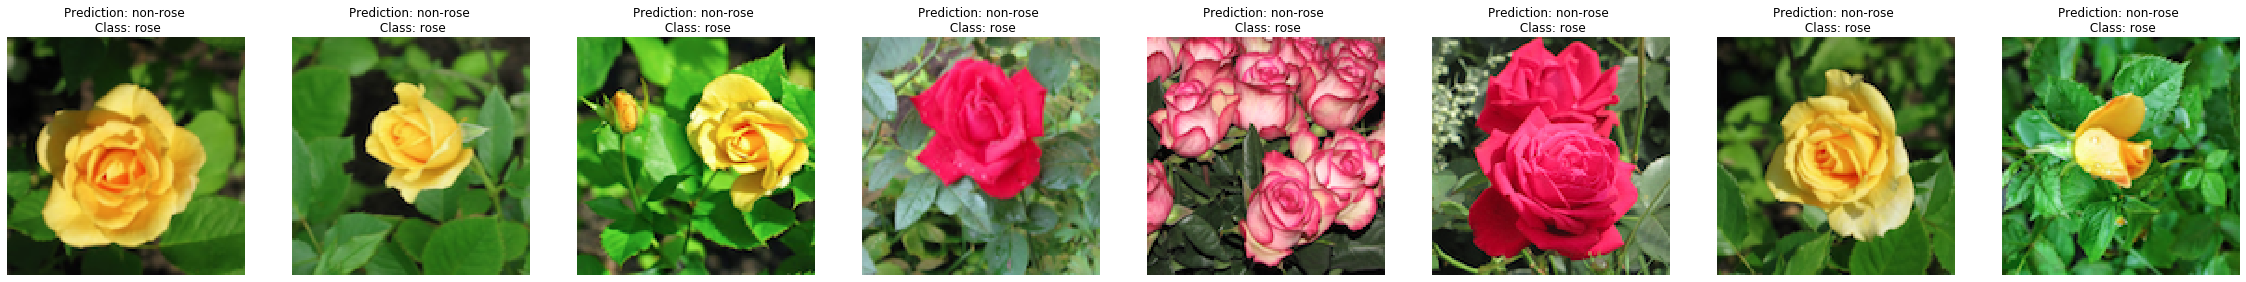

In [460]:
layers_dims = [49152, 20, 7, 5, 1]
num_iterations = 2500
learning_rate=0.0075
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate, num_iterations, print_cost = True)
pred_test = predict(test_x, test_y, parameters)
print_mislabeled_images(classes, test_x, test_y, pred_test)

##  8) RESULTS

After the develement and adaptation on the model we experiment with several modifications, above this cell are displayed some experiment but these aren't all. 

After this we found that the gratest accuracy that we can ensure is:

* Accuracy: 0.8999999999999999 
* 209 examples, 169 on the trainign set and 40 on the test set. 

We can asume that there are a lot of factors that drop down a greater result, like:

* Many roses on the picture
* Unusual rose color and species
* Camera Angle
* Brightness of the picture
* Scale variation (rose is very large or small in image)
* Shape of the flower